<a href="https://colab.research.google.com/github/AbiemwenseMaureenOshobugie/DPhi/blob/main/Data_Sprint_96_Anuran_Call_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Sprint 96 - Anuran Call Classification

Identify the Genus of the anuran species from its call

### Overview
This dataset is related to the challenge of anuran species recognition through their calls. The anurans are divided in families, genus and species.This dataset was created segmenting 60 audio records belonging to 8 genus. Each audio corresponds to one specimen (an individual frog).

 

After using the spectral entropy and a binary cluster method to detect audio frames belonging to each syllable a total of 5000 syllables were found.From each of them 22 Mel-frequency cepstral coefficients (MFCCs) were calculated. These coefficients were normalized between -1 and 1. MFCCs are coefficients that collectively make up a mel-frequency cepstrum (MFC).

 

The dataset comprises Cepstral features, which contain information about the rate changes in the different spectrum bands. The influence of the vocal cords and the vocal tract in a signal can be separated since the low-frequency excitation and the formant filtering of the vocal tract are located in different regions in the cepstral domain. The first-order coefficient represents the distribution spectral energy between low and high frequencies ( normally low frequency regions represent sonorant sound while high frequency regions represent fricative sound). The lower order coefficients contain most of the information about the overall spectral shape of the source-filter transfer function while higher order coefficients represent increasing levels of spectral details.

 
### Challenge
Your Task is to devise a Machine Learning Model that helps us to identify the Genus of the respective Anuraan species using only its call.

For more details: the Data, Dataset description, Participants, Leaderboard, click [here](https://dphi.tech/challenges/data-sprint-96-anuran-call-classification/305/leaderboard/public/)



## 1. Install and import dependencies

In [37]:
!pip install CatBoost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)


from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder


## 2. Read train and test data
Import the test and train csv files into a dataframe

In [39]:
df_train = pd.read_csv('/content/anuran_call_classification_train.csv')
df_test = pd.read_csv('/content/anuran_call_classification_test.csv')

View the first five rows of both test and train dat

In [40]:
df_train.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Genus
0,1.0,0.119781,0.295089,0.329479,0.179924,0.178956,0.127519,-0.132204,-0.063171,0.097205,...,-0.017131,-0.125876,0.028727,0.117710,0.038340,0.022927,0.013547,-0.057234,-0.020226,Hypsiboas
1,1.0,0.653562,0.924797,0.375699,0.298197,-0.032417,0.020878,0.003379,0.205143,0.078281,...,-0.043285,0.023934,0.083198,0.061530,-0.005929,0.001438,0.084545,0.087731,0.027106,Hypsiboas
2,1.0,0.060299,0.324429,0.411001,0.209832,0.185888,0.114315,-0.162366,-0.049923,0.103734,...,-0.005294,-0.089390,-0.002942,0.095505,0.032248,0.026255,0.011327,-0.073650,-0.027495,Hypsiboas
3,1.0,0.318058,0.802882,0.322736,-0.314240,0.347878,0.337821,-0.189927,-0.019588,0.204428,...,0.098808,-0.123705,-0.036430,0.082222,-0.005785,-0.041194,0.021666,0.092925,-0.000002,Leptodactylus
4,1.0,0.470661,0.301141,0.384953,0.063172,0.029145,0.140112,0.021464,-0.170095,-0.010733,...,0.104809,0.110101,-0.148516,-0.121830,0.128067,0.076941,-0.019640,-0.017236,-0.015215,Ameerega


In [41]:
df_test.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22
0,1.0,0.315318,0.497602,0.348497,-0.227228,0.287298,0.417227,-0.111509,-0.155905,0.155239,...,0.157684,0.180256,-0.069517,-0.131330,0.072044,0.037927,-0.031580,0.040856,0.142173,-0.025470
1,1.0,0.756413,0.732319,0.385807,-0.034821,0.073881,-0.058027,0.183775,0.219419,-0.445112,...,-0.177708,-0.311815,0.182382,0.030100,-0.182019,0.006296,-0.005868,0.029439,0.004783,-0.198014
2,1.0,0.415183,0.335966,0.475031,0.090405,0.005044,-0.039698,0.084663,0.240898,-0.051561,...,0.380234,-0.107244,-0.230384,0.138169,0.173223,-0.079970,-0.115304,-0.044019,0.123564,0.165076
3,1.0,0.338689,-0.064142,-0.041990,-0.033732,0.269438,0.497481,0.205565,-0.204474,-0.243321,...,0.129518,0.341234,0.147532,-0.208999,-0.193580,-0.021241,-0.027304,0.007022,0.152431,0.128729
4,1.0,0.703540,0.613362,0.410972,-0.031303,0.159498,0.210965,-0.082156,-0.004225,0.156324,...,0.180426,0.088834,-0.091483,0.028710,0.138252,0.011317,-0.025057,0.133431,0.018059,-0.074689


## 3. Explortory Data Analysis

#### The Shape of the Datasets
There are:

*   1676 rows (observations) in both the train and test datasets

*   22 columns (features) in the test and 23 columnsor features in the train.

*   The differentiating column is the feature to be predicted. This feature is also known as the Expected or Dependent variable.

This is shown by the shape function below:

In [42]:
[x.shape for x in [df_test, df_train]]

[(1676, 22), (1676, 23)]

#### Description of the data in the DataFrame.
Unlike the mean, the median is not easily influenced by outliers. Outliers distunct the shape of the data by causing it to skew to the left, if the mean is smaller than the median, or to the right, if the mean is larger than the median.

MFCCs_ 1 is the only feature from both train and test that shows observable difference between the mean and median (50%). This shows that the distributions of this feature, in both datasets, are skewed to the left. This is made visible when the code '**df.skew().sort_values(ascending=False)**' is run on both datasets.

The description of both data can be seen below:

In [43]:
df_train.describe()


,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22
count,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,...,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000
mean,0.986229,0.324950,0.347724,0.385029,0.106248,0.139614,0.040386,-0.023867,0.078227,0.059941,...,0.082730,0.002130,-0.035238,0.008040,0.028524,0.011529,-0.013808,-0.018478,0.017621,0.031685
std,0.082463,0.238597,0.301678,0.160415,0.184099,0.128277,0.171155,0.131537,0.168221,0.146964,...,0.193987,0.155280,0.176168,0.115847,0.137273,0.078171,0.081785,0.091232,0.077361,0.116135
min,-0.251179,-0.591520,-0.397932,-0.162617,-0.434950,-0.346075,-0.452555,-0.576506,-0.454282,-0.497360,...,-0.606490,-0.421427,-0.438884,-0.461007,-0.405825,-0.475986,-0.471597,-0.326972,-0.229310,-0.350161
25%,1.000000,0.169652,0.141529,0.280972,-0.004733,0.044786,-0.093328,-0.125582,-0.043273,-0.001168,...,-0.052157,-0.092763,-0.165590,-0.064875,-0.090990,-0.029581,-0.064427,-0.075232,-0.034770,-0.038119
50%,1.000000,0.305196,0.319707,0.376827,0.134128,0.142072,0.035249,-0.022280,0.094330,0.073603,...,0.074095,-0.017139,-0.048642,0.015390,0.034173,0.011834,-0.006237,-0.016632,0.007412,0.019257
75%,1.000000,0.471846,0.545007,0.505353,0.217547,0.219395,0.121465,0.061985,0.210756,0.137862,...,0.235666,0.103171,0.110211,0.070823,0.126740,0.056077,0.031336,0.031510,0.064155,0.116609
max,1.000000,1.000000,1.000000,1.000000,0.752246,0.964240,0.664746,0.520603,0.738033,0.478224,...,0.751285,0.566873,0.661947,0.427408,0.432527,0.614064,0.388499,0.467831,0.294569,0.293917


In [44]:
df_test.describe()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22
count,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,...,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000
mean,0.987141,0.324777,0.338660,0.385119,0.105995,0.139873,0.040536,-0.027087,0.076314,0.065471,...,0.091083,0.004743,-0.042929,0.006856,0.032035,0.011995,-0.012163,-0.017027,0.015460,0.029306
std,0.075446,0.243588,0.303501,0.165420,0.190093,0.124861,0.175599,0.127250,0.168747,0.145734,...,0.188695,0.157853,0.174330,0.114305,0.136330,0.078419,0.079745,0.094843,0.079188,0.120005
min,0.161325,-0.673025,-0.436028,-0.173523,-0.636012,-0.410417,-0.375170,-0.381222,-0.587313,-0.952266,...,-0.522563,-0.590380,-0.493624,-0.498675,-0.359365,-0.259136,-0.389656,-0.335619,-0.430812,-0.379304
25%,1.000000,0.167998,0.127558,0.277623,-0.005201,0.045891,-0.094692,-0.126832,-0.042450,0.008091,...,-0.040609,-0.086650,-0.168625,-0.056393,-0.079258,-0.034619,-0.061521,-0.076182,-0.035356,-0.044863
50%,1.000000,0.312524,0.313092,0.376426,0.134137,0.142016,0.030884,-0.021684,0.092975,0.077752,...,0.077734,-0.016463,-0.053384,0.014664,0.035265,0.012156,-0.004588,-0.017232,0.006786,0.016650
75%,1.000000,0.476415,0.538921,0.510411,0.221164,0.217965,0.122902,0.061538,0.211680,0.140651,...,0.247242,0.111629,0.100951,0.069345,0.129151,0.055398,0.029535,0.035892,0.066128,0.117255
max,1.000000,1.000000,1.000000,1.000000,0.712662,0.805794,1.000000,0.371527,0.570043,0.476308,...,0.557759,0.575749,0.607228,0.381773,0.349858,0.525165,0.574209,0.358280,0.387363,0.327623


#### Null Values and Data Types

*   There are no null values in both datsets

*   All the columns (features) have a data-type of float, except the Genus in the train data, the data-type is object. 

The Genus is the dependent variable.



In [45]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MFCCs_ 1  1676 non-null   float64
 1   MFCCs_ 2  1676 non-null   float64
 2   MFCCs_ 3  1676 non-null   float64
 3   MFCCs_ 4  1676 non-null   float64
 4   MFCCs_ 5  1676 non-null   float64
 5   MFCCs_ 6  1676 non-null   float64
 6   MFCCs_ 7  1676 non-null   float64
 7   MFCCs_ 8  1676 non-null   float64
 8   MFCCs_ 9  1676 non-null   float64
 9   MFCCs_10  1676 non-null   float64
 10  MFCCs_11  1676 non-null   float64
 11  MFCCs_12  1676 non-null   float64
 12  MFCCs_13  1676 non-null   float64
 13  MFCCs_14  1676 non-null   float64
 14  MFCCs_15  1676 non-null   float64
 15  MFCCs_16  1676 non-null   float64
 16  MFCCs_17  1676 non-null   float64
 17  MFCCs_18  1676 non-null   float64
 18  MFCCs_19  1676 non-null   float64
 19  MFCCs_20  1676 non-null   float64
 20  MFCCs_21  1676 non-null   floa

In [46]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MFCCs_ 1  1676 non-null   float64
 1   MFCCs_ 2  1676 non-null   float64
 2   MFCCs_ 3  1676 non-null   float64
 3   MFCCs_ 4  1676 non-null   float64
 4   MFCCs_ 5  1676 non-null   float64
 5   MFCCs_ 6  1676 non-null   float64
 6   MFCCs_ 7  1676 non-null   float64
 7   MFCCs_ 8  1676 non-null   float64
 8   MFCCs_ 9  1676 non-null   float64
 9   MFCCs_10  1676 non-null   float64
 10  MFCCs_11  1676 non-null   float64
 11  MFCCs_12  1676 non-null   float64
 12  MFCCs_13  1676 non-null   float64
 13  MFCCs_14  1676 non-null   float64
 14  MFCCs_15  1676 non-null   float64
 15  MFCCs_16  1676 non-null   float64
 16  MFCCs_17  1676 non-null   float64
 17  MFCCs_18  1676 non-null   float64
 18  MFCCs_19  1676 non-null   float64
 19  MFCCs_20  1676 non-null   float64
 20  MFCCs_21  1676 non-null   floa

#### Unique Values
The values in both datasets have as many unique values in the features as the number of observations, except feature MFCCs_ 1.

This shows that the call of an anuran is unique. See the cell below:

In [47]:
# Check for unique values in the columns
for i in df_test.columns:
    n = df_train[i].nunique()
    m = df_test[i].nunique()
    print(f'Feature {i} has {n} in train and {m} in test')


Feature MFCCs_ 1 has 78 in train and 78 in test
Feature MFCCs_ 2 has 1662 in train and 1659 in test
Feature MFCCs_ 3 has 1619 in train and 1623 in test
Feature MFCCs_ 4 has 1673 in train and 1673 in test
Feature MFCCs_ 5 has 1676 in train and 1676 in test
Feature MFCCs_ 6 has 1676 in train and 1676 in test
Feature MFCCs_ 7 has 1676 in train and 1676 in test
Feature MFCCs_ 8 has 1676 in train and 1676 in test
Feature MFCCs_ 9 has 1676 in train and 1676 in test
Feature MFCCs_10 has 1676 in train and 1676 in test
Feature MFCCs_11 has 1676 in train and 1676 in test
Feature MFCCs_12 has 1676 in train and 1676 in test
Feature MFCCs_13 has 1676 in train and 1676 in test
Feature MFCCs_14 has 1676 in train and 1676 in test
Feature MFCCs_15 has 1676 in train and 1676 in test
Feature MFCCs_16 has 1676 in train and 1676 in test
Feature MFCCs_17 has 1676 in train and 1676 in test
Feature MFCCs_18 has 1676 in train and 1676 in test
Feature MFCCs_19 has 1676 in train and 1676 in test
Feature MFCCs_20

#### The Dependent Variable



*   This is the column that makes the difference between the train and test datasets.

*   This is the target variable, Genus. The Genus feature is made up of 8 unique values.

*   The 8 unique values represents the classes of the anurans' call.

*   This feature shows a class imbalance in the train data: the 'Hypsiboas' class has 500 observations while the 'Rhinella' class has 34 observations, with the other 6 classes in between.

This can be observed below:





In [48]:
df_train["Genus"].value_counts()


Hypsiboas        500
Adenomera        450
Ameerega         271
Dendropsophus    155
Leptodactylus    135
Scinax            74
Osteocephalus     57
Rhinella          34
Name: Genus, dtype: int64

## 4. Preprocessing: 
a. Split data into predictors and target


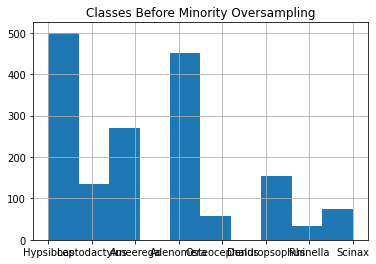

In [49]:
# split into input and output elements
X = df_train.drop('Genus', axis = 1) 

# define target variables
y = df_train['Genus']

y.hist()
plt.title('Classes Before Minority Oversampling')
plt.show()

b. Balance the target class

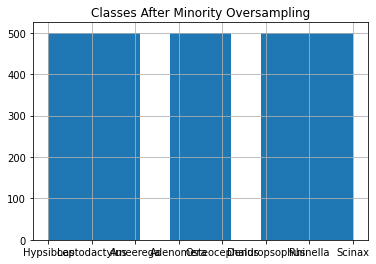

In [50]:
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# summarize distribution
y.hist()
plt.title('Classes After Minority Oversampling')
plt.show()

In [51]:
# see the new shape of the resampled data
print(X.shape, y.shape)

(4000, 22) (4000,)


c. Further split X into train and test sets

In [52]:
# Set test size to 20 % of training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, df_test.shape)

(3200, 22) (800, 22) (3200,) (800,) (1676, 22)


## 5. Modeling
### Logistic Regression Classifier

In [53]:
from numpy.ma.core import log2
from sklearn.linear_model import LogisticRegression
# call Logistic Regression classifier model with define parameters
clf = LogisticRegression(
    C=100.0,
    penalty = 'l2',
    class_weight="balanced",
    solver="newton-cg",
    multi_class="multinomial",
    n_jobs=-1,
    random_state=40,
)

# train the model with data from tfidf transformer
clf.fit(X_train, y_train)


LogisticRegression(C=100.0, class_weight='balanced', multi_class='multinomial',
                   n_jobs=-1, random_state=40, solver='newton-cg')

In [54]:
log_pred = clf.predict(X_test)

#evaluate the performance with confusion metrix, F1 measure, accuracy
print('Logistic Regression confusion_matrix')
print(confusion_matrix(y_test,log_pred))
print('Logistic Regression classification_report')
print(classification_report(y_test,log_pred))
print('Logistic Regression accuracy_score')
print(accuracy_score(y_test,log_pred))


Logistic Regression confusion_matrix
[[ 95   2   2   0   0   0   1   1]
 [  1  97   0   0   0   0   0   0]
 [  1   2 102   0   0   0   0   1]
 [  1   0   0  96   1   3   0   1]
 [  0   0   0   1  93   1   0   0]
 [  0   0   0   1   0  91   0   0]
 [  0   0   0   0   0   0  90   0]
 [  0   0   0   0   0   0   0 116]]
Logistic Regression classification_report
               precision    recall  f1-score   support

    Adenomera       0.97      0.94      0.95       101
     Ameerega       0.96      0.99      0.97        98
Dendropsophus       0.98      0.96      0.97       106
    Hypsiboas       0.98      0.94      0.96       102
Leptodactylus       0.99      0.98      0.98        95
Osteocephalus       0.96      0.99      0.97        92
     Rhinella       0.99      1.00      0.99        90
       Scinax       0.97      1.00      0.99       116

     accuracy                           0.97       800
    macro avg       0.98      0.98      0.98       800
 weighted avg       0.98      0.9

In [55]:
# example of grid searching key hyperparametres for SVC

model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.994271 using {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.991563 (0.004503) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.994062 (0.004142) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.735833 (0.021886) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.992083 (0.004249) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.994271 (0.003134) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.774896 (0.021552) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.987812 (0.004729) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.984271 (0.007102) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.846771 (0.018087) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.949688 (0.013267) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.913646 (0.017650) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.762813 (0.022088) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.662604 (0.021355) with: {'C': 0.01, 'gamma': 'scale', 

### Support Vector Classifier

In [56]:
svc = SVC(C = 50, 
          gamma = 'scale', 
          kernel = 'rbf',
          random_state = 0
          )

# train the model with data from tfidf transformer
svc.fit(X_train, y_train)

SVC(C=50, random_state=0)

In [57]:
svc_pred = svc.predict(X_test)

#evaluate the performance with confusion metrix, F1 measure, accuracy
print('Support Vector confusion_matrix')
print(confusion_matrix(y_test,svc_pred))
print('Support Vector classification_report')
print(classification_report(y_test,svc_pred))
print('Support Vector accuracy_score')
print(accuracy_score(y_test,svc_pred))


Support Vector confusion_matrix
[[100   0   0   0   0   0   0   1]
 [  0  98   0   0   0   0   0   0]
 [  1   0 105   0   0   0   0   0]
 [  0   0   0  99   0   3   0   0]
 [  0   0   0   0  95   0   0   0]
 [  0   0   0   0   0  92   0   0]
 [  0   0   0   0   0   0  90   0]
 [  0   0   0   0   0   0   0 116]]
Support Vector classification_report
               precision    recall  f1-score   support

    Adenomera       0.99      0.99      0.99       101
     Ameerega       1.00      1.00      1.00        98
Dendropsophus       1.00      0.99      1.00       106
    Hypsiboas       1.00      0.97      0.99       102
Leptodactylus       1.00      1.00      1.00        95
Osteocephalus       0.97      1.00      0.98        92
     Rhinella       1.00      1.00      1.00        90
       Scinax       0.99      1.00      1.00       116

     accuracy                           0.99       800
    macro avg       0.99      0.99      0.99       800
 weighted avg       0.99      0.99      0.9

### GradientBoosting Classifier

In [58]:
gbc = GradientBoostingClassifier(learning_rate=0.2,
                                max_features='log2',
                                n_estimators=20,
                                random_state=10,
                                max_depth = 20,
                                subsample=0.8)

# train the model with data from tfidf transformer
gbc.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.2, max_depth=20, max_features='log2',
                           n_estimators=20, random_state=10, subsample=0.8)

In [59]:
gbc_pred = gbc.predict(X_test)

#evaluate the performance with confusion metrix, F1 measure, accuracy
print('Gradient Boosting confusion_matrix')
print(confusion_matrix(y_test,gbc_pred))
print('Gradient Boosting classification_report')
print(classification_report(y_test,gbc_pred))
print('Gradient Boosting accuracy_score')
print(accuracy_score(y_test,gbc_pred))


Gradient Boosting confusion_matrix
[[ 98   1   2   0   0   0   0   0]
 [  0  98   0   0   0   0   0   0]
 [  1   0 105   0   0   0   0   0]
 [  0   0   0  99   2   1   0   0]
 [  0   0   0   1  93   1   0   0]
 [  0   0   0   0   0  92   0   0]
 [  0   0   0   0   0   0  90   0]
 [  0   0   0   0   0   0   0 116]]
Gradient Boosting classification_report
               precision    recall  f1-score   support

    Adenomera       0.99      0.97      0.98       101
     Ameerega       0.99      1.00      0.99        98
Dendropsophus       0.98      0.99      0.99       106
    Hypsiboas       0.99      0.97      0.98       102
Leptodactylus       0.98      0.98      0.98        95
Osteocephalus       0.98      1.00      0.99        92
     Rhinella       1.00      1.00      1.00        90
       Scinax       1.00      1.00      1.00       116

     accuracy                           0.99       800
    macro avg       0.99      0.99      0.99       800
 weighted avg       0.99      0.99   

### XGB Classifier

In [60]:
xgc = XGBClassifier(eta = 0.2,
                    max_depth = 20,
                    min_child_weight = 0.1,
                    gamma = 0,
                    colsample_bytree = 0.8,
                    scale_pos_weight = 0.3,
                    use_label_encoder=True, 
                    eval_metric="logloss")

# train the model with data from tfidf transformer
xgc.fit(X_train, y_train)


XGBClassifier(colsample_bytree=0.8, eta=0.2, eval_metric='logloss',
              max_depth=20, min_child_weight=0.1, objective='multi:softprob',
              scale_pos_weight=0.3, use_label_encoder=True)

In [61]:
xgc_pred = xgc.predict(X_test)

#evaluate the performance with confusion metrix, F1 measure, accuracy
print('XGB Classifier confusion_matrix')
print(confusion_matrix(y_test,xgc_pred))
print('XGB Classifier classification_report')
print(classification_report(y_test,xgc_pred))
print('XGB Classifier accuracy_score')
print(accuracy_score(y_test,xgc_pred))


XGB Classifier confusion_matrix
[[100   0   1   0   0   0   0   0]
 [  0  98   0   0   0   0   0   0]
 [  1   0 105   0   0   0   0   0]
 [  0   0   1  99   0   2   0   0]
 [  0   1   0   0  93   1   0   0]
 [  0   0   0   0   0  92   0   0]
 [  0   0   0   0   0   0  90   0]
 [  0   0   0   0   0   0   0 116]]
XGB Classifier classification_report
               precision    recall  f1-score   support

    Adenomera       0.99      0.99      0.99       101
     Ameerega       0.99      1.00      0.99        98
Dendropsophus       0.98      0.99      0.99       106
    Hypsiboas       1.00      0.97      0.99       102
Leptodactylus       1.00      0.98      0.99        95
Osteocephalus       0.97      1.00      0.98        92
     Rhinella       1.00      1.00      1.00        90
       Scinax       1.00      1.00      1.00       116

     accuracy                           0.99       800
    macro avg       0.99      0.99      0.99       800
 weighted avg       0.99      0.99      0.9

### Random Forest Classifier

In [62]:
rfc = RandomForestClassifier(n_estimators= 800,
                             min_samples_split= 2,
                             min_samples_leaf= 1,
                             max_features= 'sqrt',
                             max_depth= 90,
                             bootstrap= False,
                             random_state=42)

# train the model with data from tfidf transformer
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=90, max_features='sqrt',
                       n_estimators=800, random_state=42)

In [63]:
rfc_pred = rfc.predict(X_test)

#evaluate the performance with confusion metrix, F1 measure, accuracy
print('Random Forest confusion_matrix')
print(confusion_matrix(y_test,rfc_pred))
print('Random Forest classification_report')
print(classification_report(y_test,rfc_pred))
print('Random Forest accuracy_score')
print(accuracy_score(y_test,rfc_pred))



Random Forest confusion_matrix
[[ 99   0   2   0   0   0   0   0]
 [  0  98   0   0   0   0   0   0]
 [  1   0 105   0   0   0   0   0]
 [  0   0   1 101   0   0   0   0]
 [  0   0   0   2  93   0   0   0]
 [  0   0   0   0   0  92   0   0]
 [  0   0   0   0   0   0  90   0]
 [  0   0   0   0   0   0   0 116]]
Random Forest classification_report
               precision    recall  f1-score   support

    Adenomera       0.99      0.98      0.99       101
     Ameerega       1.00      1.00      1.00        98
Dendropsophus       0.97      0.99      0.98       106
    Hypsiboas       0.98      0.99      0.99       102
Leptodactylus       1.00      0.98      0.99        95
Osteocephalus       1.00      1.00      1.00        92
     Rhinella       1.00      1.00      1.00        90
       Scinax       1.00      1.00      1.00       116

     accuracy                           0.99       800
    macro avg       0.99      0.99      0.99       800
 weighted avg       0.99      0.99      0.99 

### CatBoost Classifier

In [64]:
cbc = CatBoostClassifier()

# train the model with data from tfidf transformer
cbc.fit(X_train, y_train)

Learning rate set to 0.083963
0:	learn: 1.7929445	total: 58.2ms	remaining: 58.1s
1:	learn: 1.5767297	total: 97.3ms	remaining: 48.5s
2:	learn: 1.4118644	total: 139ms	remaining: 46.2s
3:	learn: 1.2894888	total: 177ms	remaining: 44.1s
4:	learn: 1.1731160	total: 221ms	remaining: 43.9s
5:	learn: 1.0771839	total: 260ms	remaining: 43.2s
6:	learn: 0.9949159	total: 300ms	remaining: 42.5s
7:	learn: 0.9170253	total: 337ms	remaining: 41.8s
8:	learn: 0.8528753	total: 380ms	remaining: 41.8s
9:	learn: 0.7987898	total: 418ms	remaining: 41.4s
10:	learn: 0.7458157	total: 462ms	remaining: 41.6s
11:	learn: 0.6968037	total: 505ms	remaining: 41.6s
12:	learn: 0.6571171	total: 545ms	remaining: 41.4s
13:	learn: 0.6203375	total: 586ms	remaining: 41.3s
14:	learn: 0.5861211	total: 624ms	remaining: 41s
15:	learn: 0.5552477	total: 665ms	remaining: 40.9s
16:	learn: 0.5269347	total: 704ms	remaining: 40.7s
17:	learn: 0.5001778	total: 743ms	remaining: 40.5s
18:	learn: 0.4766488	total: 781ms	remaining: 40.3s
19:	learn: 

In [65]:
cbc_pred = cbc.predict(X_test)

#evaluate the performance with confusion metrix, F1 measure, accuracy
print('Cat Boost confusion_matrix')
print(confusion_matrix(y_test,cbc_pred))
print('Cat Boost classification_report')
print(classification_report(y_test,cbc_pred))
print('Cat Boost accuracy_score')
print(accuracy_score(y_test,cbc_pred))


Cat Boost confusion_matrix
[[ 99   0   2   0   0   0   0   0]
 [  0  98   0   0   0   0   0   0]
 [  1   0 105   0   0   0   0   0]
 [  0   0   0  98   1   3   0   0]
 [  0   0   0   2  93   0   0   0]
 [  0   0   0   0   0  92   0   0]
 [  0   0   0   0   0   0  90   0]
 [  0   0   0   0   0   0   0 116]]
Cat Boost classification_report
               precision    recall  f1-score   support

    Adenomera       0.99      0.98      0.99       101
     Ameerega       1.00      1.00      1.00        98
Dendropsophus       0.98      0.99      0.99       106
    Hypsiboas       0.98      0.96      0.97       102
Leptodactylus       0.99      0.98      0.98        95
Osteocephalus       0.97      1.00      0.98        92
     Rhinella       1.00      1.00      1.00        90
       Scinax       1.00      1.00      1.00       116

     accuracy                           0.99       800
    macro avg       0.99      0.99      0.99       800
 weighted avg       0.99      0.99      0.99       80

### Stacking Classifier

In [66]:
from sklearn.ensemble import StackingClassifier

estimators = [
     ('RF',rfc),
     ('GB', gbc),
     ('XG', xgc),
     ('CB', cbc),
     ('SVC', svc)
]

skc = StackingClassifier(
     estimators=estimators, final_estimator=CatBoostClassifier(max_depth=4, random_state=42))

skc.fit(X_train, y_train)


Streaming output truncated to the last 5000 lines.
4:	learn: 1.2137977	total: 221ms	remaining: 43.9s
5:	learn: 1.1171753	total: 257ms	remaining: 42.7s
6:	learn: 1.0385188	total: 295ms	remaining: 41.8s
7:	learn: 0.9651183	total: 332ms	remaining: 41.1s
8:	learn: 0.9011974	total: 374ms	remaining: 41.2s
9:	learn: 0.8371724	total: 417ms	remaining: 41.3s
10:	learn: 0.7866512	total: 455ms	remaining: 40.9s
11:	learn: 0.7386103	total: 496ms	remaining: 40.9s
12:	learn: 0.6980732	total: 533ms	remaining: 40.4s
13:	learn: 0.6558463	total: 571ms	remaining: 40.2s
14:	learn: 0.6246658	total: 613ms	remaining: 40.3s
15:	learn: 0.5943529	total: 651ms	remaining: 40s
16:	learn: 0.5642941	total: 689ms	remaining: 39.8s
17:	learn: 0.5363562	total: 728ms	remaining: 39.7s
18:	learn: 0.5114756	total: 766ms	remaining: 39.6s
19:	learn: 0.4876307	total: 804ms	remaining: 39.4s
20:	learn: 0.4642963	total: 849ms	remaining: 39.6s
21:	learn: 0.4476038	total: 889ms	remaining: 39.5s
22:	learn: 0.4276284	total: 927ms	remai

StackingClassifier(estimators=[('RF',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=90,
                                                       max_features='sqrt',
                                                       n_estimators=800,
                                                       random_state=42)),
                               ('GB',
                                GradientBoostingClassifier(learning_rate=0.2,
                                                           max_depth=20,
                                                           max_features='log2',
                                                           n_estimators=20,
                                                           random_state=10,
                                                           subsample=0.8)),
                               ('XG',
                                XGBClassifier(colsample_bytree=

In [67]:
skc_pred = skc.predict(X_test)

#evaluate the performance with confusion metrix, F1 measure, accuracy
print('Stacking confusion_matrix')
print(confusion_matrix(y_test,skc_pred))
print('Stacking classification_report')
print(classification_report(y_test,skc_pred))
print('Stacking accuracy_score')
print(accuracy_score(y_test,skc_pred))


Stacking confusion_matrix
[[100   0   1   0   0   0   0   0]
 [  0  98   0   0   0   0   0   0]
 [  1   0 105   0   0   0   0   0]
 [  0   0   1 100   0   1   0   0]
 [  0   0   0   2  93   0   0   0]
 [  0   0   0   0   0  92   0   0]
 [  0   0   0   0   0   0  90   0]
 [  0   0   0   0   0   0   0 116]]
Stacking classification_report
               precision    recall  f1-score   support

    Adenomera       0.99      0.99      0.99       101
     Ameerega       1.00      1.00      1.00        98
Dendropsophus       0.98      0.99      0.99       106
    Hypsiboas       0.98      0.98      0.98       102
Leptodactylus       1.00      0.98      0.99        95
Osteocephalus       0.99      1.00      0.99        92
     Rhinella       1.00      1.00      1.00        90
       Scinax       1.00      1.00      1.00       116

     accuracy                           0.99       800
    macro avg       0.99      0.99      0.99       800
 weighted avg       0.99      0.99      0.99       800


Conclusion: All the models perform very well, nearly perfect. The Support Vector classifier, however ouperformed the others with an accuracy score of **0.99375**. this ws closely followed by 0.9925 from Random forest Classifier.

# **Thank you!**

## Prediction and Submission


In [ ]:
#  make prediction with test data
predict_skc = skc.predict(df_test)

# To create Dataframe for prediction
submission = pd.DataFrame(predict_skc)
submission.columns = ["Genus"]

submission.to_csv('stacking1.csv', index = False)
